In [5]:
import sys
sys.path.append("..")

from utils.processing import LoFTRHomographyEstimation
import endoscopy
from endoscopy.homography_estimator import HomographyEstimator
loftr = LoFTRHomographyEstimation()
deep = HomographyEstimator(endoscopy.MODEL.HOMOGRAPHY_ESTIMATION.H_64_RESNET_34)

/home/martin/miniconda3/envs/torch110/lib/python3.9/site-packages/torch/serialization.py:602: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


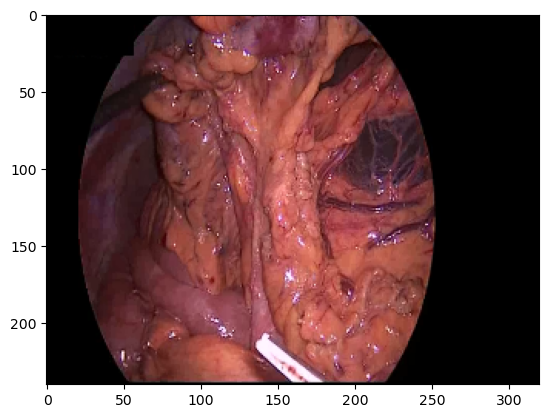

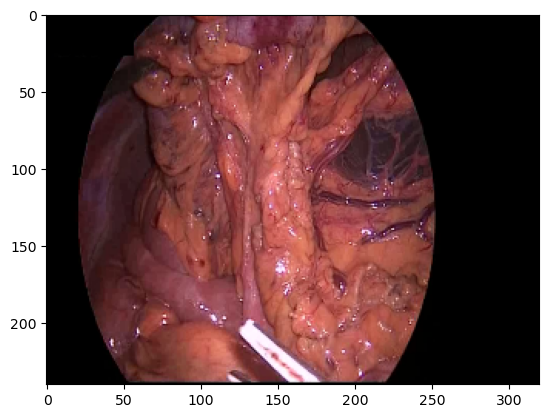

In [47]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kornia import image_to_tensor, tensor_to_image

cholec = False
idx_0 = 200
idx_p = idx_0 + 10
if cholec:
    prefix = "/media/martin/Samsung_T5/data/endoscopic_data/cholec80_frames"
    df = pd.read_pickle(f"{prefix}/log.pkl")
    img = np.load(f"{prefix}/{df.iloc[idx_0].folder}/{df.iloc[idx_0].file}")
    wrp = np.load(f"{prefix}/{df.iloc[idx_p].folder}/{df.iloc[idx_p].file}")
else:
    prefix = "/media/martin/Samsung_T5/data/endoscopic_data/10s_video"
    img = cv2.imread(f"{prefix}/{idx_0}.png")[:,:,::-1].copy()
    wrp = cv2.imread(f"{prefix}/{idx_p}.png")[:,:,::-1].copy()

img = cv2.resize(img, [320, 240]) 
wrp = cv2.resize(wrp, [320, 240])

plt.imshow(img)
plt.show()
plt.imshow(wrp)
plt.show()

img_t = image_to_tensor(img, False).float()/255.
wrp_t = image_to_tensor(wrp, False).float()/255.

In [48]:
duv_loftr = loftr(img_t, wrp_t)
h_deep, duv_deep = deep(img_t, wrp_t)

from utils.processing import image_edges, four_point_homography_to_matrix
from utils.viz import yt_alpha_blend

h_loftr = four_point_homography_to_matrix(image_edges(img_t), -duv_loftr)

from kornia.geometry import warp_perspective
wrp_t_loftr = warp_perspective(img_t, h_loftr, img_t.shape[-2:])
wrp_t_deep = warp_perspective(img_t, h_deep.inverse(), img_t.shape[-2:])
blend_t_loftr = yt_alpha_blend(wrp_t, wrp_t_loftr)
blend_t_deep = yt_alpha_blend(wrp_t, wrp_t_deep)

import cv2

cv2.imwrite(f"/tmp/estimation/idx_0_{idx_0}_idx_p_{idx_p}_loftr.png", (tensor_to_image(blend_t_loftr, False)*255).astype(np.uint8))
cv2.imwrite(f"/tmp/estimation/idx_0_{idx_0}_idx_p_{idx_p}_deep.png", (tensor_to_image(blend_t_deep, False)*255).astype(np.uint8))

True